In [13]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import torch
from torchvision import datasets
import numpy as np
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2

if 'google.colab' in sys.modules:
    !pip install torchsummary
    !pip install albumentationsx

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

from model_v1 import Net

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 36.6 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.33 which is incompatible.


In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"Cuda available = {is_cuda}, Using device = {device}")

Cuda available = True, Using device = cuda


In [4]:
# Mean and Standard Deviation of CIFAR-10 dataset
CIFAR10_MEAN = (0.49139968, 0.48215827, 0.44653124)
CIFAR10_STD = (0.24703233, 0.24348505, 0.26158768)
if 'google.colab' in sys.modules:
    BATCH_SIZE = 512
else:
    BATCH_SIZE = 32
CIFAR10_LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
GET_DATASET_STATS_FLAG = True

In [5]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # CIFAR10 gives PIL image -> convert to numpy
        img = np.array(img)
        # Apply Albumentations
        augmented = self.transform(image=img)
        return augmented["image"]

train_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625),
        scale_limit=(-0.1, 0.1),
        rotate_limit=(-45, 45),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        rotate_method="largest_box",
        p=0.5),
    A.CoarseDropout(
        num_holes_range=(1, 3),
        hole_height_range=(5, 15),
        hole_width_range=(5, 15),
        fill_value=0,
        p=0.5
    ),
    A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ToTensorV2(),
]))

test_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ToTensorV2(),
]))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3528236369.py:23: UserWarning: Argument(s) 'fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [6]:
cifar_train_dataset = datasets.CIFAR10(
    root='../../',
    train=True,
    download=True,
    transform=train_transforms,
)

cifar_test_dataset = datasets.CIFAR10(
    root='../../',
    train=False,
    download=True,
    transform=test_transforms,
)

train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 2, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 2, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

100%|██████████| 170M/170M [00:06<00:00, 27.0MB/s]


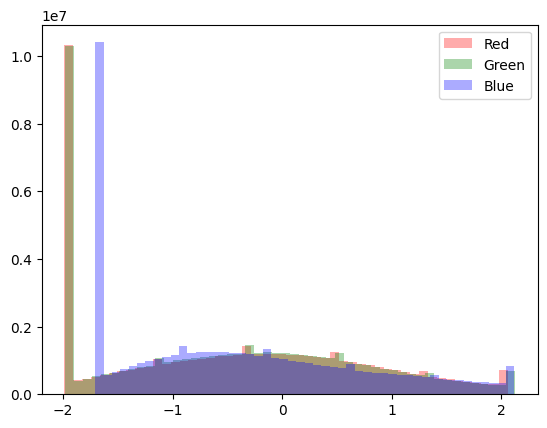

In [7]:
if GET_DATASET_STATS_FLAG:
    imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [8]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].squeeze(0)
        image_data = image_data.permute(1,2,0)
        plt.imshow(image_data)
        plt.title(CIFAR10_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

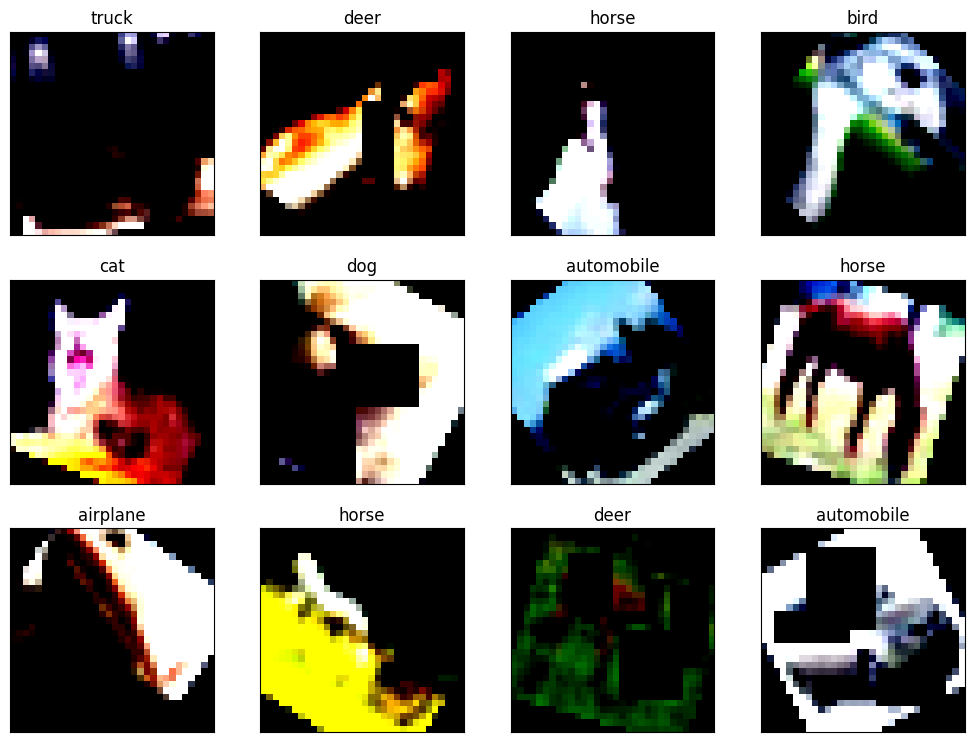

In [9]:
dataset_visualizer(train_loader)

In [10]:
criterion = nn.CrossEntropyLoss()
train_loss_data = []
train_accuracy = []
test_loss_data = []
test_accuracy = []

best_loss = float('inf')   # initialize with infinity

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx}')

    # Epoch-level stats
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total

    train_loss_data.append(avg_loss)
    train_accuracy.append(acc)

    print(f'\nTrain set (epoch {epoch}): Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({acc:.2f}%)\n')


def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'Test set (epoch {epoch}): Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        if 'google.colab' in sys.modules:
            torch.save(model.state_dict(), "/content/drive/MyDrive/CIFAR10/best_model.pt")
        else:
            torch.save(model.state_dict(), "best_model.pt")
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


In [11]:
model = Net().to(device)

dummy_data = torch.randn(5, 3, 32, 32).to(device)
dummy_output = model(dummy_data)
logger.info(f"CNN output shape = {dummy_output.shape}")
summary(model, input_size=(3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,320
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]             544
       BatchNorm2d-8           [-1, 32, 32, 32]              64
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           9,248
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

In [12]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1,  patience=10)

for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader, epoch)
    reduce_lr.step(test_loss)

loss=1.3990 batch_id=195: 100%|██████████| 196/196 [00:30<00:00,  6.40it/s]


Train set (epoch 0): Average loss: 1.7319, Accuracy: 18016/50000 (36.03%)



Test set (epoch 0): Average loss: 1.4904, Accuracy: 4495/10000 (44.95%)

✅ Saved new best model at epoch 0 with loss 1.4904


loss=1.5311 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


Train set (epoch 1): Average loss: 1.4301, Accuracy: 23909/50000 (47.82%)



Test set (epoch 1): Average loss: 1.3559, Accuracy: 5131/10000 (51.31%)

✅ Saved new best model at epoch 1 with loss 1.3559


loss=1.3786 batch_id=195: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]


Train set (epoch 2): Average loss: 1.3056, Accuracy: 26204/50000 (52.41%)



Test set (epoch 2): Average loss: 1.3118, Accuracy: 5288/10000 (52.88%)

✅ Saved new best model at epoch 2 with loss 1.3118


loss=0.9784 batch_id=195: 100%|██████████| 196/196 [00:33<00:00,  5.91it/s]


Train set (epoch 3): Average loss: 1.2196, Accuracy: 27786/50000 (55.57%)



Test set (epoch 3): Average loss: 1.4391, Accuracy: 5350/10000 (53.50%)



loss=1.3412 batch_id=195: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]


Train set (epoch 4): Average loss: 1.1590, Accuracy: 29200/50000 (58.40%)



Test set (epoch 4): Average loss: 1.2302, Accuracy: 5756/10000 (57.56%)

✅ Saved new best model at epoch 4 with loss 1.2302


loss=1.2932 batch_id=195: 100%|██████████| 196/196 [00:30<00:00,  6.47it/s]


Train set (epoch 5): Average loss: 1.1202, Accuracy: 29993/50000 (59.99%)



Test set (epoch 5): Average loss: 1.2106, Accuracy: 5986/10000 (59.86%)

✅ Saved new best model at epoch 5 with loss 1.2106


loss=1.3525 batch_id=195: 100%|██████████| 196/196 [00:29<00:00,  6.60it/s]


Train set (epoch 6): Average loss: 1.0803, Accuracy: 30656/50000 (61.31%)



Test set (epoch 6): Average loss: 1.1585, Accuracy: 6036/10000 (60.36%)

✅ Saved new best model at epoch 6 with loss 1.1585


loss=1.0577 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]


Train set (epoch 7): Average loss: 1.0411, Accuracy: 31469/50000 (62.94%)



Test set (epoch 7): Average loss: 0.9869, Accuracy: 6514/10000 (65.14%)

✅ Saved new best model at epoch 7 with loss 0.9869


loss=1.3900 batch_id=195: 100%|██████████| 196/196 [00:30<00:00,  6.35it/s]


Train set (epoch 8): Average loss: 1.0144, Accuracy: 31955/50000 (63.91%)



Test set (epoch 8): Average loss: 0.9735, Accuracy: 6697/10000 (66.97%)

✅ Saved new best model at epoch 8 with loss 0.9735


loss=0.9121 batch_id=195: 100%|██████████| 196/196 [00:30<00:00,  6.49it/s]


Train set (epoch 9): Average loss: 0.9848, Accuracy: 32581/50000 (65.16%)



Test set (epoch 9): Average loss: 1.0030, Accuracy: 6602/10000 (66.02%)



loss=0.7591 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]


Train set (epoch 10): Average loss: 0.9632, Accuracy: 32981/50000 (65.96%)



Test set (epoch 10): Average loss: 0.8506, Accuracy: 7022/10000 (70.22%)

✅ Saved new best model at epoch 10 with loss 0.8506


loss=0.8714 batch_id=195: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]


Train set (epoch 11): Average loss: 0.9433, Accuracy: 33348/50000 (66.70%)



Test set (epoch 11): Average loss: 0.9582, Accuracy: 6718/10000 (67.18%)



loss=0.9183 batch_id=195: 100%|██████████| 196/196 [00:32<00:00,  6.08it/s]


Train set (epoch 12): Average loss: 0.9214, Accuracy: 33765/50000 (67.53%)



Test set (epoch 12): Average loss: 0.9112, Accuracy: 6888/10000 (68.88%)



loss=0.7342 batch_id=195: 100%|██████████| 196/196 [00:30<00:00,  6.36it/s]


Train set (epoch 13): Average loss: 0.9076, Accuracy: 34047/50000 (68.09%)



Test set (epoch 13): Average loss: 0.9810, Accuracy: 6736/10000 (67.36%)



loss=1.0028 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


Train set (epoch 14): Average loss: 0.8934, Accuracy: 34316/50000 (68.63%)



Test set (epoch 14): Average loss: 0.9574, Accuracy: 6816/10000 (68.16%)



loss=0.8022 batch_id=195: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]


Train set (epoch 15): Average loss: 0.8792, Accuracy: 34514/50000 (69.03%)



Test set (epoch 15): Average loss: 0.7907, Accuracy: 7344/10000 (73.44%)

✅ Saved new best model at epoch 15 with loss 0.7907


loss=1.1286 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.84it/s]


Train set (epoch 16): Average loss: 0.8654, Accuracy: 34747/50000 (69.49%)



Test set (epoch 16): Average loss: 0.9137, Accuracy: 7031/10000 (70.31%)



loss=0.8109 batch_id=195: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]



Train set (epoch 17): Average loss: 0.8560, Accuracy: 34912/50000 (69.82%)

Test set (epoch 17): Average loss: 0.7541, Accuracy: 7396/10000 (73.96%)

✅ Saved new best model at epoch 17 with loss 0.7541


loss=0.8088 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.83it/s]


Train set (epoch 18): Average loss: 0.8415, Accuracy: 35046/50000 (70.09%)



Test set (epoch 18): Average loss: 0.9350, Accuracy: 6939/10000 (69.39%)



loss=0.9093 batch_id=195: 100%|██████████| 196/196 [00:28<00:00,  6.84it/s]


Train set (epoch 19): Average loss: 0.8355, Accuracy: 35377/50000 (70.75%)



Test set (epoch 19): Average loss: 0.7802, Accuracy: 7336/10000 (73.36%)



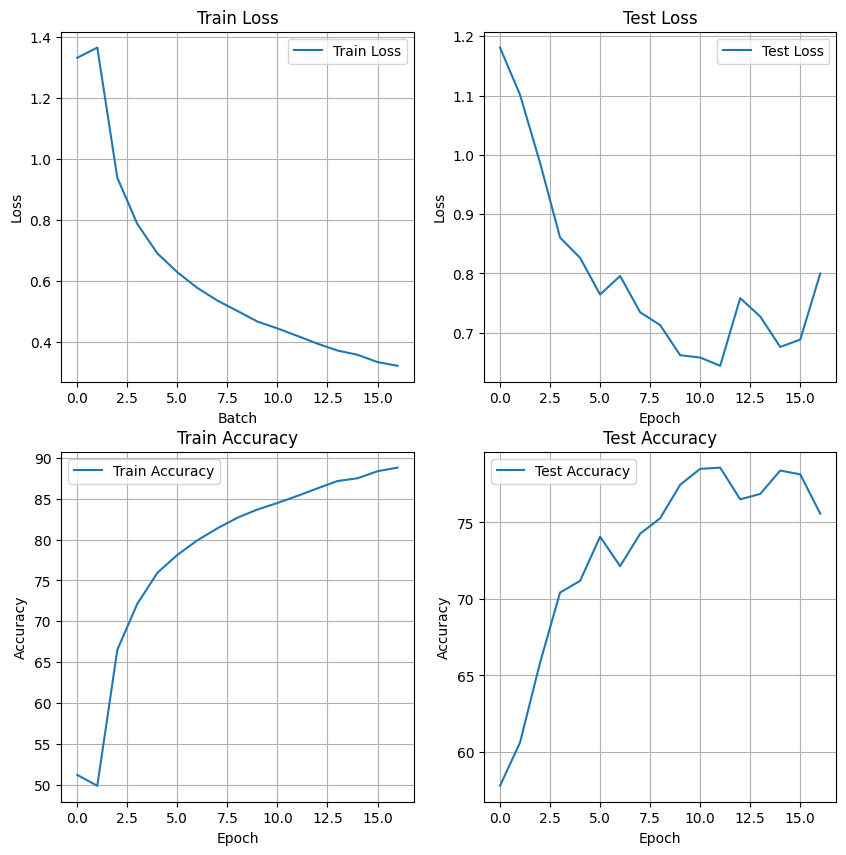

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(train_loss_data, label='Train Loss')
axs[0,0].set_xlabel('Batch')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Train Loss')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(test_loss_data, label='Test Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Test Loss')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(train_accuracy, label='Train Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('Train Accuracy')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(test_accuracy, label='Test Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Test Accuracy')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()